In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from IPython.display import Image, display
import pandas as pd
from typing import Any, Annotated
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
import numpy as np

In [2]:
# import plotly.express as px
# import json

# def plotly_to_echarts(fig):
#     echarts_json = {
#         "title": {"text": fig.layout.title.text if fig.layout.title else ""},
#         "tooltip": {"trigger": "axis"},
#         "legend": {"data": []},
#         "xAxis": {"type": "category", "data": []},
#         "yAxis": {"type": "value"},
#         "series": []
#     }
    
#     for trace in fig.data:
#         series_data = {
#             "name": trace.name if trace.name else "Series",
#             "type": "line" if trace.mode == "lines" else "bar",
#             "data": []
#         }
        
#         if "x" in trace:
#             echarts_json["xAxis"]["data"] = trace.x.tolist()
#         print("type trace.y",type(trace.y))
#         if "y" in trace:
#             series_data["data"] = trace.y.tolist()
        
#         echarts_json["series"].append(series_data)
#         echarts_json["legend"]["data"].append(series_data["name"])
#     print("echarts_json::",type(echarts_json))
#     return echarts_json

# # Example usage:
# fig = px.line(x=[1, 2, 3, 4], y=[10, 20, 15, 25], title="Example Plotly Chart")
# echarts_json = plotly_to_echarts(fig)
# print(json.dumps(echarts_json))

In [3]:
GROQ_API_KEY = "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"

In [4]:
llm = ChatGroq(temperature=0.1, groq_api_key=GROQ_API_KEY, model_name="llama-3.3-70b-specdec")

In [5]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """    
    error: str
    data_path: str
    question: str
    input_data: dict[str, Any]
    data_schema: str
    data_summary: str
    messages: Annotated[list, add_messages]
    user_query: str
    code: str
    final_results: dict[str, Any]
    final_answer: dict[str, Any]
    

    # class Config:
    #     arbitrary_types_allowed = True

In [6]:
def json_df(json_str)->pd.DataFrame:
    import pandas as pd
    from io import StringIO
    json_buffer = StringIO(json_str)
    df = pd.read_json(json_buffer, orient='split')
    return df

In [7]:
# inside execute.py

import io
import sys

def execute_generated_code(code, df):
    print("Started executing generated code")
    # Clean the code by removing block markers and spaces
    # clean_code = code.strip('```').strip()  
    clean_code = code.replace('```','###')
    clean_code = clean_code.replace("fig.show()","# fig.show()")
    print('111::',clean_code)
    # Redirect stdout to capture print statements
    # output_buffer = io.StringIO()
    # sys.stdout = output_buffer  
    print('222')
    # Pass your DataFrame to the local scope
    local_scope = {"df": df}
    print('333')
    try:
        print('444')
        # Execute the code with the DataFrame in the local scope
        exec(clean_code, {}, local_scope)
        print('555')
    except Exception as e:
        print("Error executing generated code::",e)
        return f"Error during execution: {e}"
    finally:
        print("finally")
        # Reset stdout to default after execution
        # sys.stdout = sys.__stdout__
    print("befre return")
    # Return both the output captured and the local scope (for plots or other variables)
    # output = output_buffer.getvalue()
    print("Ended executing generated code")
    return local_scope

In [8]:
def load_data(state: GraphState):
    print(state["data_path"])
    df = pd.read_csv(state["data_path"])
    # df = pd.DataFrame({"name": ["Alice", "Bob"]})
    # print(df.shape)
    return {"input_data":df.to_json(orient='split')}

In [9]:
def summarize_data(state: GraphState):
    
    df_json = state['input_data']
    df = None
    if df_json is not None:
        df = json_df(df_json)
        print("summarize_data df shape:", df.shape)
    else:
        return {"data_summary": None}
    columns = list(df.columns)
    data_types = df.dtypes.to_dict()

    unique_values = {}

    # for column in df.columns:
    #     if df[column].dtype == 'object' or df[column].dtype.name == 'category':
    #         unique_values[column] = df[column].unique().tolist()
    #     elif 'datetime' in str(df[column].dtype):
    #         date_sample = df[column].dropna().iloc[0]
    #         inferred_format = pd.to_datetime([date_sample]).strftime('%Y-%m-%d')[0]
    #         unique_values[column] = f"Date format: {inferred_format}"


    summary = (
        f"Columns: {columns}\n"
        f"Data Types: {data_types}\n"
        # f"Unique Values for Categorical/Date Columns:\n{unique_values}"
    )
    
    return {"data_summary":summary}

In [10]:
def human_userinput(state):
    print("---human_input1---")    
    user_msg = interrupt("Enter query")
    # state['user_query']=user_msg
    # user_msg = "What is the data schema?"
    return {"user_query": user_msg, "messages": [HumanMessage(user_msg)]}
    # return {"messages": [HumanMessage(user_msg)]}

In [11]:
# def generate_code1(state: GraphState):
#     print("---generate_code---")
#     data_summary = state["data_summary"]
#     # query = state["user_query"]
#     message = state["messages"][-1].content
#     print("message:", message)
#     system_message = (
#         f"You are a professional data analyst proficient in Python programming.\n"
#         f"Based on the following dataset summary:\n{data_summary}\n"
#         "Provide clean python code using pandas and plotly (only the code, nothing else) that when executed will:\n"
#         "The code should contain a visualization that is well labelled."
#         "Assume the dataset has been read into a dataframe called df." 
#         "If the query involves generating a chart (e.g., bar plot), please ensure the chart displays no more than 10 categories (top or bottom)."
#         "If the user specifically requests to show all categories, include that in the code. If no specific instruction is provided, limit the chart to the top or bottom 10 categories based on the count or value"
#         f" Answer the user's question: '{message}'.\n"
#     )
#     print("before llm generate",system_message)
#     response = llm.invoke(system_message)
#     print("after llm generate",response)
#     return {"code": response.content}

In [12]:
def generate_code(state: GraphState):
    print("---generate_code---")
    data_summary = state["data_summary"]
    # query = state["user_query"]
    message = state["messages"][-1].content
    print("message:", message)
    system_message = (
        f"You are a professional data analyst proficient in Python programming.\n"
        f"Based on the following dataset summary:\n{data_summary}\n"
        "Provide clean python code using pandas and plotly (only the code, nothing else) that when executed will:\n"
        "The code should contain a visualization that is well labelled.\n"
        "Assume the dataset has been read into a dataframe called df.\n" 
        "If the query involves generating a chart (e.g., bar plot), please ensure the chart displays no more than 10 categories (top or bottom).\n"
        "If the user specifically requests to show all categories, include that in the code. If no specific instruction is provided, limit the chart to the top or bottom 10 categories based on the count or value\n"
        "Make sure all the important results are saved as a dictionary with name 'final_results'. \n"
        "For plotly fig object, include type as 'figure'."
        "Each result item should be dictionary with keys value, type and description about that item. Example :{'type':'str','value':'There are 10 counties', 'description':'Count of counties'}"
        # "For objects with datatypes not serializable like pandas DataFrame or Series, assign serialized data to value."
        "Make sure the generated code is surrounded with try and catch . In exception handler print the error."
        f" Answer the user's question: '{message}'.\n"
    )
    print("before llm generate",system_message)
    response = llm.invoke(system_message)
    print("after llm generate",response)
    return {"code": response.content}

In [13]:
def convert_arrays_to_lists(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert NumPy arrays and Pandas Series to lists
    elif isinstance(obj, pd.Series):
        return obj.to_json(orient='index')
    elif isinstance(obj, pd.DataFrame):
        return obj.to_json(orient='records')
    elif isinstance(obj, dict):
        return {key: convert_arrays_to_lists(value) for key, value in obj.items()}  # Recursively process dict
    elif isinstance(obj, list):
        return [convert_arrays_to_lists(item) for item in obj]  # Recursively process lists
    else:
        return obj  # Return as is if it's not an array/series

In [14]:
def execute_code(state: GraphState):
    print("-----Executing code----")
    gen_code = state["code"]
    data = json_df(state["input_data"])
    results = execute_generated_code(gen_code, data)
    if "df" in results:
        del results["df"]
    final_results = None
    if results is not None and 'final_results' in results:
        # final_results = convert_arrays_to_lists(results['final_results'])
        final_results = results['final_results']
        for k,v in final_results.items():
            print("K::",k,v["type"])
            if "type" in v:
                if str.lower(v["type"]) == "figure":
                    # print("$$$$$$$$$$$",k,"::::::",v)
                    final_results[k]['value']=v['value'].to_json()
                elif str.lower(v["type"]) == "series":
                    print("before conversion")
                    final_results[k]['value']=v['value'].astype(str).to_json(orient='index')
                    print("after conversion")
                elif str.lower(v["type"]) == "dataframe":
                    # print("$$$$$$$$$$$",k,"::::::",v)
                    final_results[k]['value']=v['value'].to_json(orient='split')
            else:
                if 'Series' in str(type(final_results[k]['value'])):
                    final_results[k]['type'] = 'series'
                elif 'DataFrame' in str(type(final_results[k]['value'])):
                    final_results[k]['type'] = 'dataframe'
                else:
                    final_results[k]['type'] = str(type(final_results[k]['value']))
        # print("final_results::",final_results)
    #     return {"final_results":final_results}
    
    # else:
    #     return {"final_results":""}
    final_answer = prepare_answer(state['user_query'],final_results)
    return {"final_answer":final_answer}

    

In [15]:
def prepare_answer(user_query: str, fin_results: dict):
    print("----prepare answer-----")
    if fin_results is None:
        return None
    plots = []
    text_outputs= []
    tables = []
    for k, v in fin_results.items():
        print("K::",v['type'])
        if "type" in v and v['type'].startswith('fig'):
            plots.append(v['value'])
        elif "type" in v and v['type'].lower() == 'series':
            
            ser = v
            # ser['value']=ser['value'].to_json(orient='index')
            tables.append(ser)
        elif "type" in v and v['type'].lower() == 'dataframe':
            tab = v
            # tab['value']=tab['value'].to_json(orient='split')
            tables.append(tab)
        else:
            text_outputs.append({k:v})
    
    final_answer = {}
    if len(text_outputs)>0:
        answer_prompt = f"""Generate the brief answer for the given question using the related JSON data
                        Query: {user_query}
                        JSON: {text_outputs}
                        Answer:
                        """
        resp = llm.invoke(answer_prompt)
        final_answer['text_answer']=resp.content
    else:
        final_answer['text_answer']= None
    final_answer['tables']=tables
    final_answer['visualization']=plots
    print("final_answer############", final_answer)
    return final_answer
    
        

In [16]:
def prep_ans(state: GraphState):
    return {"final_answer":"Final answer by the bot"}

In [17]:
builder = StateGraph(GraphState)

builder.add_node("load_data", load_data)
builder.add_node("summarize_data", summarize_data)
builder.add_node("human_userinput", human_userinput)
builder.add_node("generate_code", generate_code)
builder.add_node("execute_code", execute_code)
# builder.add_node("prep_ans", prep_ans)
builder.add_edge(START, "load_data")
builder.add_edge("load_data", "summarize_data")
builder.add_edge("summarize_data", "human_userinput")
builder.add_edge("human_userinput", "generate_code")
builder.add_edge("generate_code", "execute_code")
# builder.add_edge("generate_code", "prep_ans")
builder.add_edge("execute_code", END)


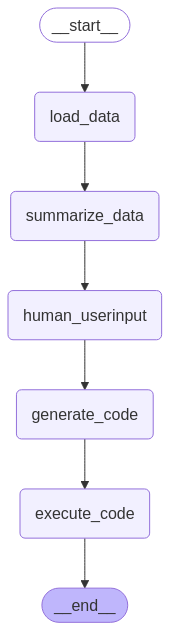

In [18]:
# Set up memory
memory = MemorySaver()
# memory = SqliteSaver.from_conn_string(":memory:")
# Add
graph = builder.compile(checkpointer=memory)
# graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
# Input
initial_input = {"data_path": r"D:\suresh\work\projects\W360_MVP1\playground\notebooks\data\Electric_Vehicle_Population_Data.csv"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    # print(event)
    print("\n")

D:\suresh\work\projects\W360_MVP1\playground\notebooks\data\Electric_Vehicle_Population_Data.csv


summarize_data df shape: (177866, 17)


---human_input1---




In [20]:
graph.get_state(thread).next

('human_userinput',)

In [ ]:
user_text = "Show me the summary of the given dataset?"
for event in graph.stream(Command(resume=user_text), thread, stream_mode="values"):
        # print(event)
        print("\n")

In [22]:
fin_results = graph.get_state(thread).values

In [23]:
fin_results['final_answer'].keys()

dict_keys(['text_answer', 'tables', 'visualization'])

In [26]:
fin_results['final_answer']['visualization']

['{"data":[{"hovertemplate":"x=%{x}\\u003cbr\\u003ey=%{y}\\u003cextra\\u003e\\u003c\\u002fextra\\u003e","legendgroup":"","marker":{"color":"#636efa","pattern":{"shape":""}},"name":"","orientation":"v","showlegend":false,"textposition":"auto","x":["King","Snohomish","Pierce","Clark","Thurston","Kitsap","Spokane","Whatcom","Benton","Skagit"],"xaxis":"x","y":{"dtype":"i4","bdata":"RGoBAAlSAADWNQAAsCgAABwZAADQFgAA6hEAAJ0QAABjCAAAdgcAAA=="},"yaxis":"y","type":"bar"}],"layout":{"template":{"data":{"histogram2dcontour":[{"type":"histogram2dcontour","colorbar":{"outlinewidth":0,"ticks":""},"colorscale":[[0.0,"#0d0887"],[0.1111111111111111,"#46039f"],[0.2222222222222222,"#7201a8"],[0.3333333333333333,"#9c179e"],[0.4444444444444444,"#bd3786"],[0.5555555555555556,"#d8576b"],[0.6666666666666666,"#ed7953"],[0.7777777777777778,"#fb9f3a"],[0.8888888888888888,"#fdca26"],[1.0,"#f0f921"]]}],"choropleth":[{"type":"choropleth","colorbar":{"outlinewidth":0,"ticks":""}}],"histogram2d":[{"type":"histogram2d"

In [21]:
user_text = "How many counties are there?"
for event in graph.stream(Command(resume=user_text), thread, stream_mode="values"):
        # print(event)
        print("\n")




---human_input1---


---generate_code---
message: How many counties are there?
before llm generate You are a professional data analyst proficient in Python programming.
Based on the following dataset summary:
Columns: ['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract']
Data Types: {'VIN (1-10)': dtype('O'), 'County': dtype('O'), 'City': dtype('O'), 'State': dtype('O'), 'Postal Code': dtype('float64'), 'Model Year': dtype('int64'), 'Make': dtype('O'), 'Model': dtype('O'), 'Electric Vehicle Type': dtype('O'), 'Clean Alternative Fuel Vehicle (CAFV) Eligibility': dtype('O'), 'Electric Range': dtype('int64'), 'Base MSRP': dtype('int64'), 'Legislative District': dtype('float64'), 'DOL Vehicle ID': dtype('int64'), 'Vehicle Location': dtype('O'), '

In [ ]:
for k, v in event.items():
    print(k)

In [ ]:
fin_results.keys()

In [ ]:
'X'.lower()

In [ ]:
plots = []
text_outputs= []
for k, v in fin_results.items():
    if "type" in v and v['type'].startswith('fig'):
        plots.append(v['value'])
    else:
        text_outputs.append({k:v})
    # print(k,v)
    # break

In [ ]:
text_outputs

In [ ]:
user_query = graph.get_state(thread).values['user_query']
print(user_query)

In [ ]:
answer_prompt = f"""Generate the brief answer for the given question using the related JSON data
Query: {user_query}
JSON: {text_outputs}
Answer:
"""
print(answer_prompt)

In [ ]:
resp = llm.invoke(answer_prompt)

In [ ]:
resp.content

In [ ]:
with open("plot_data.json", "w") as f:
    f.write(fin_results['fig']['value'])


In [ ]:
x = {"a":10,"b":20}
print(x)

In [ ]:
type(x)

In [ ]:
df_json = graph.get_state(thread).values['input_data']
input_df = json_df(df_json)
print(input_df.shape)

In [ ]:
!pip show plotly

In [ ]:
code1 = graph.get_state(thread).values['code'].replace("```","")
print(code1)

In [ ]:
input_df.head()

In [ ]:
code = """```python
import pandas as pd
import plotly.express as px

# Get the number of unique counties
num_counties = df['County'].nunique()
print(f"There are {num_counties} counties.")

# Get the top 10 counties by count
top_10_counties = df['County'].value_counts().head(10)

# Create a bar plot
fig = px.bar(x=top_10_counties.index, y=top_10_counties.values, title="Top 10 Counties by Count", labels={'x': 'County', 'y': 'Count'})
fig.show()
```"""

In [ ]:
print(code)

In [ ]:
clean_code = code.strip('```').strip()  
print(clean_code)

In [ ]:
import io
import sys

In [ ]:
output_buffer = io.StringIO()
sys.stdout = output_buffer 

In [ ]:
clean_code = code.strip('```').strip()  
print('111::')
# Redirect stdout to capture print statements
output_buffer = io.StringIO()
sys.stdout = output_buffer  
print('222')
# Pass your DataFrame to the local scope
local_scope = {"df": df}
print('333')


In [ ]:
import pandas as pd
df = pd.read_csv(r"D:\suresh\work\projects\W360_MVP1\playground\notebooks\data\Electric_Vehicle_Population_Data.csv")

In [ ]:
data_types = df.dtypes

In [ ]:
dtypes_as_strings = df.dtypes.astype(str)

In [ ]:
dtypes_as_strings.to_dict()

In [ ]:
data_types.to_dict()

In [ ]:
dtypes_as_strings.to_json()

In [ ]:
dtypes_as_strings.to_json(orient='index')

In [ ]:
data_types.to_json(orient='index')

In [ ]:
data_types.values

In [ ]:
data_types